In [1]:
# Parallell Physics Informed Neural Networks
# Use phys_loss_weight to set the weight of the physics loss. Higher weight (~>1) puts stronger
# constraints on the model to abide by the differential equations, and lower weight (<1) 
# prioritizes fitting the model to the data over the model agreeing with the differential equations

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

#from model import PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)
/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)


S2 145
S13 127
S18 142


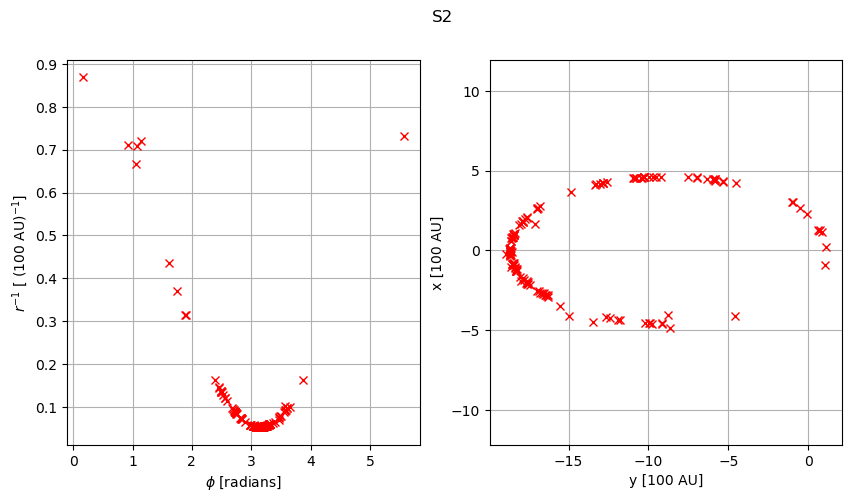

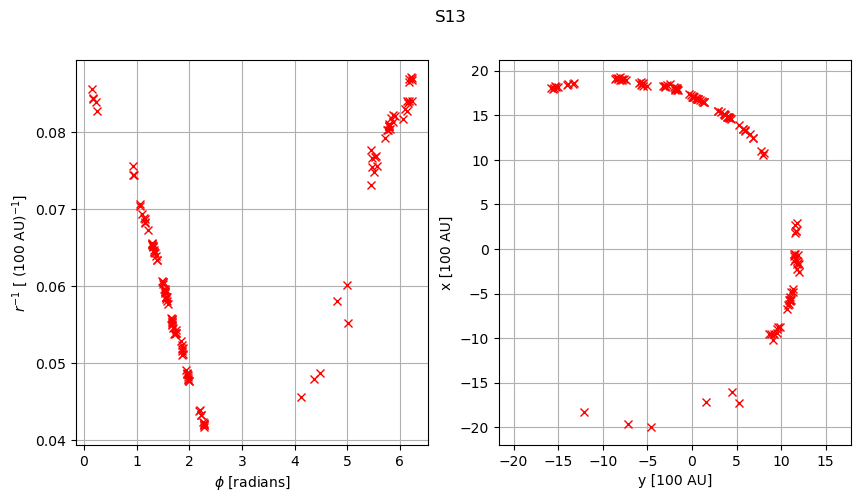

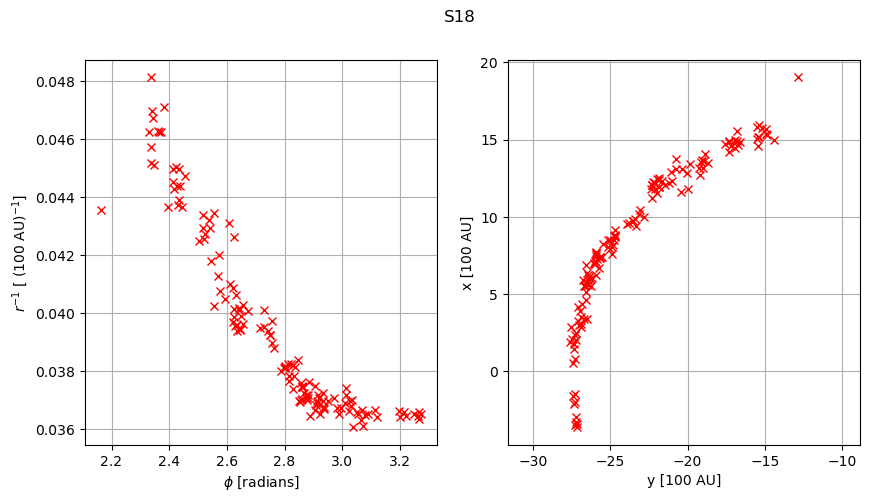

In [83]:
from SLoader import SLoader
scaling = 1e-2

loaders = []
# S18
# S19? S21? S38? S55?
stars = ["S2", "S13", "S18"]

for star in stars:
    SL = SLoader(star=star, scaling=scaling)
    print(star, len(SL))
    loaders.append(SL)


for i, loader in enumerate(loaders):
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    fig.suptitle(stars[i])
    ax[0].plot(loader.phi, loader.u, 'rx')
    ax[0].set_ylabel(r"$r^{-1}$ [ (100 AU)$^{-1}$]")
    ax[0].set_xlabel(r"$\phi$ [radians]")
    ax[0].grid()

    ax[1].plot(loader.x, loader.y, 'rx')
    ax[1].set_ylabel(r"x [100 AU]")
    ax[1].set_xlabel(r"y [100 AU]")
    ax[1].grid()
    ax[1].axis('equal');


In [84]:

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True,
                               allow_unused=True)



class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5], dropout_prob=0.1):
        super().__init__()

        #self.in_block = nn.Linear(in_chan, chans[0])

        layers = []

        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.Tanh())
        #layers.append(nn.Dropout(p=dropout_prob))

        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.Tanh())
            #layers.append(nn.Dropout(p=dropout_prob))

        layers.append(nn.Linear(chans[-1], out_chan))

        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        #y = torch.sin(self.in_block(x))
        #return self.blocks(y)
    
        return self.blocks(x)


class PINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()
        self.nn = NNBlock(in_chan, out_chan, chans=chans)

        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))

    def forward(self, x, M):
        mu = self.get_mu()
        e  = self.get_e()
        u = mu/M * (1 + e*torch.cos(self.nn(x)))
        return u
    
    def get_e(self):
        return torch.abs(self.e_)
    
    def get_M(self):
        return torch.abs(self.M_)
    
    def get_mu(self):
        return torch.abs(self.mu_)

    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        chi = self.nn(phi)

        mu = self.get_mu()
        e  = self.get_e()

        dchi = torch.autograd.grad(chi, phi, 
                               grad_outputs=torch.ones_like(chi), 
                               create_graph=True,
                               allow_unused=True)[0]
        
        ddchi = torch.autograd.grad(dchi, 
                               phi, 
                               grad_outputs=torch.ones_like(dchi), 
                               create_graph=True)[0]
    

        ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
        ode2 = ddchi - mu*e*torch.sin(chi)

        # L2 Loss
        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)
        
        loss1 *= lambda1
        loss2 *= lambda2

        return loss1 + loss2
    

class PPINN(nn.Module):
    def __init__(self, NPINNs=2, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()

        self.pinns = nn.ModuleList([])
        for i in range(NPINNs):
            self.pinns.append(PINN(in_chan, out_chan, chans))

        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))

    def get_M(self):
        return torch.abs(self.M_)    
    
    def forward(self, *phi):
        u = []

        for i, phi_ in enumerate(phi):
            u.append(self.pinns[i](phi_, M=self.get_M()))
    
        return u
        #M  = self.get_M()

    def physical_loss(self, *phi):
        loss = []

        for i, phi_ in enumerate(phi):
            loss.append(self.pinns[i].physical_loss(phi_))

        return loss

In [ ]:
# Initialize model
lr = 1e-3

model = PPINN(NPINNs=len(stars), in_chan=1, out_chan=1, chans=[16]*3).to(device)

optimizer = optim.Adam(lr=lr, params=model.parameters(), weight_decay=0.0)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()


losses = [[[], []] for _ in range(len(stars))]
params = [[[], []] for _ in range(len(stars))]
mass = []

#phi_lin = torch.linspace(-2.1*torch.pi, 4.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
N = 2.  # How many pi do I want to extend the angles with, when evaluating the physics
phi_lin = torch.linspace(-torch.pi*N, 2*torch.pi + torch.pi*N, steps=256).view(-1,1).requires_grad_(True)

#phys_loss_weight = 5e-3
phys_loss_weight = 1e-1

batch_size = 64
batch_size_phys = 64

epoch = 0

In [93]:
epochs = 10_000

for j in tqdm(range(epochs)):
    epoch += 1

    loss = 0
    ind_p = torch.tensor(random.sample(range(len(phi_lin)), batch_size_phys))

    for i, loader in enumerate(loaders):
        ind = torch.tensor(random.sample(range(len(loader.phi)), batch_size))

        phi_ = loader.phi[ind]
        phi_ = (phi_ + (torch.randint(low=0,high=3,size=phi_.shape) - 1) * 2 * torch.pi)

        u_ = loader.u[ind]
        phi_lin_ = phi_lin[ind_p]

        out = model.pinns[i](phi_, M=model.get_M())
        MSEloss = criterion(out, u_)

        PHYSloss = model.pinns[i].physical_loss(phi_lin_)
        PHYSloss *= phys_loss_weight

        losses[i][0].append(MSEloss.item())
        losses[i][1].append(PHYSloss.item())

        loss += MSEloss + PHYSloss

        params[i][0].append(model.pinns[i].get_e().item())
        params[i][1].append(model.pinns[i].get_mu().item())

    mass.append(model.get_M().item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


100%|██████████| 15000/15000 [04:10<00:00, 59.84it/s]


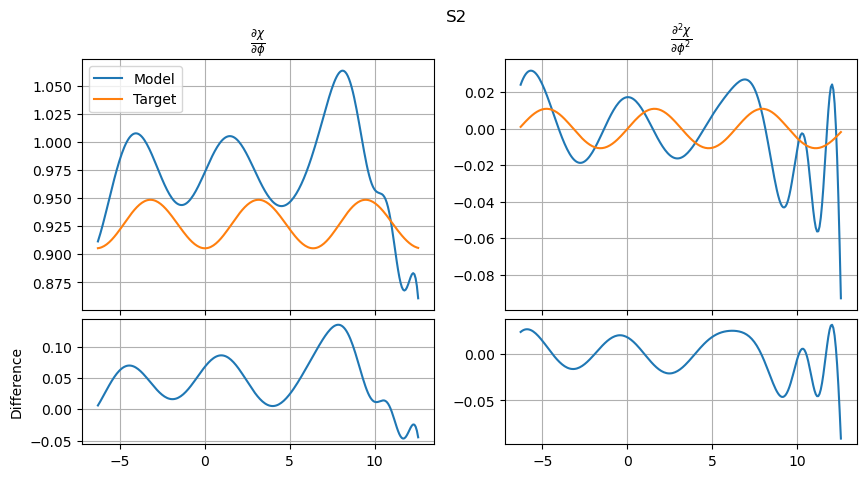

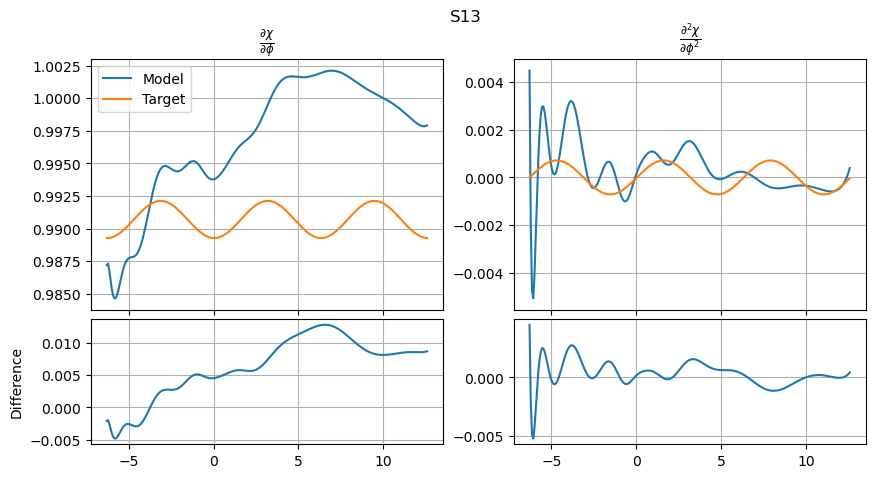

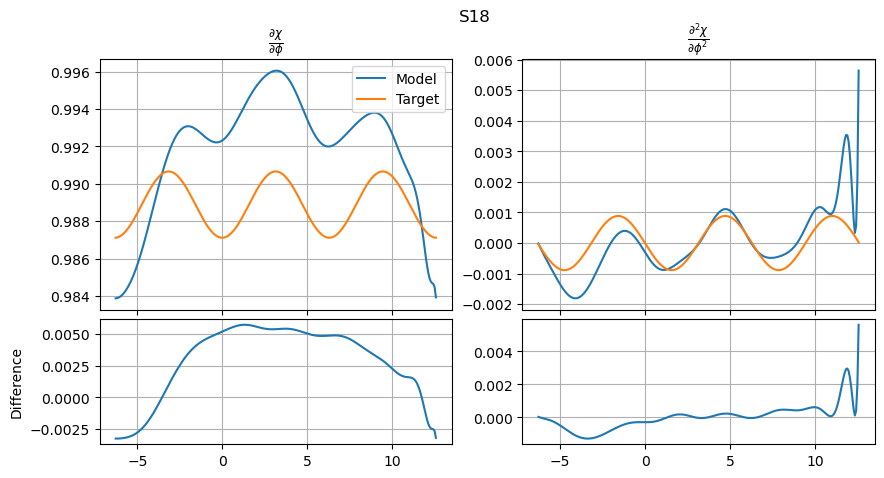

In [94]:
def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)

for i, pinn in enumerate(model.pinns):
    _phi = phi_lin
    chi = pinn.nn(_phi)

    mu = pinn.get_mu().item()
    e  = pinn.get_e().item()

    dchi = grad(chi, _phi)[0]
    ddchi = grad(dchi, _phi)[0]

    ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
    ode2 = ddchi - mu*e*torch.sin(chi)

    _phi = _phi.detach().numpy()
    dchi = dchi.detach().numpy()
    ddchi = ddchi.detach().numpy()
    chi = chi.detach()
    ode1 = ode1.detach().numpy()
    ode2 = ode2.detach().numpy()

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
    fig.suptitle(stars[i])
    ax[0,0].grid()
    ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
    ax[0,0].plot(_phi, dchi**2, label="Model")
    ax[0,0].plot(_phi, (1 - 2*mu*(3 + e*torch.cos(chi))), label="Target")
    ax[0,0].legend()

    ax[0,1].grid()
    ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
    ax[0,1].plot(_phi, ddchi)
    ax[0,1].plot(_phi, mu*e*torch.sin(chi))

    ax[1,0].grid()
    ax[1,0].set_ylabel("Difference")
    ax[1,0].plot(_phi, ode1)

    ax[1,1].grid()
    ax[1,1].plot(_phi, ode2)

    plt.subplots_adjust(hspace=.05)

M [AU] = 0.026525016874074936

 S2
e = 0.8840977549552917
p [AU] = 217.59976798338843
mu = 0.012189818546175957
a [AU] = 996.4675202497243
M-model-data = 0.9678536057472229

 S13
e = 0.4596650004386902
p [AU] = 1710.3310157166316
mu = 0.0015508703654631972
a [AU] = 2168.5222240032567
M-model-data = 0.9793061017990112

 S18
e = 0.47824299335479736
p [AU] = 1432.1904966400296
mu = 0.0018520592711865902
a [AU] = 1856.8920999371585
M-model-data = 0.987715482711792


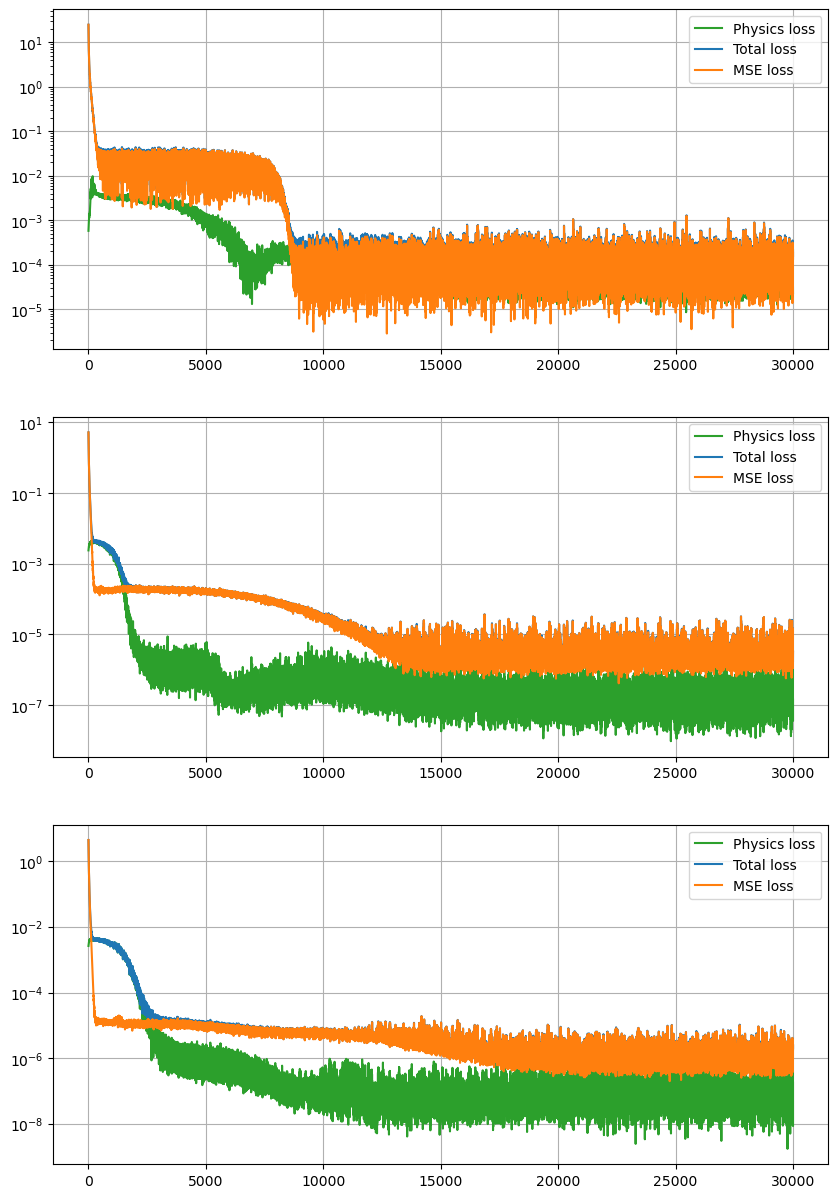

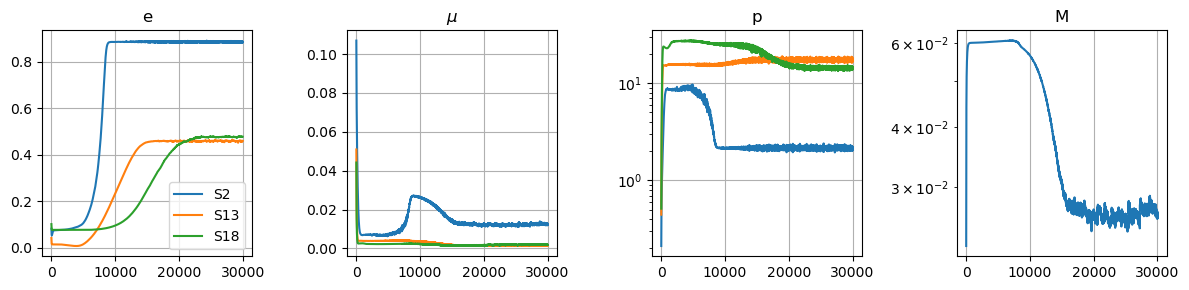

In [100]:
print("M [AU] =", model.get_M().item())

for i, loader in enumerate(loaders):
    print("\n", stars[i])
    print("e =", model.pinns[i].get_e().item())
    print("p [AU] =", model.get_M().item()/model.pinns[i].get_mu().item() / scaling)
    print("mu =", model.pinns[i].get_mu().item())
    print("a [AU] =", model.get_M().item() / model.pinns[i].get_mu().item() / (1 - model.pinns[i].get_e().item()**2) / scaling)

    M_md = torch.mean(1 - torch.abs(model.pinns[i](loader.phi.to(device), M=model.get_M()).cpu() - loader.u)/loader.u).item()
    print("M-model-data =", M_md)



fig, ax = plt.subplots(nrows=len(stars), figsize=(10,5*len(stars)))

for i, loss in enumerate(losses):
    ax[i].plot(loss[1], label="Physics loss", c="tab:green")
    ax[i].plot(np.array(loss[0]) + np.array(loss[1]), label="Total loss", c="tab:blue")
    ax[i].plot(loss[0], label="MSE loss", c="tab:orange")
    ax[i].grid()
    ax[i].legend()
    ax[i].set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=4, figsize=(12,3))

for i, param in enumerate(params):
    ax[0].plot(param[0], label=stars[i])

    ax[1].plot(param[1])

    ax[2].plot(np.array(mass)/np.array(param[1]))


ax[0].legend()
ax[0].set_title("e")
ax[0].grid()

ax[1].set_title(r"$\mu$")
ax[1].grid()

ax[2].set_title("p")
ax[2].grid()
ax[2].set_yscale("log")

ax[3].plot(mass)
ax[3].set_title("M")
ax[3].grid()
ax[3].set_yscale("log")



plt.tight_layout()
plt.show()

# S2
# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU

# M-model-data ~ 0.9755

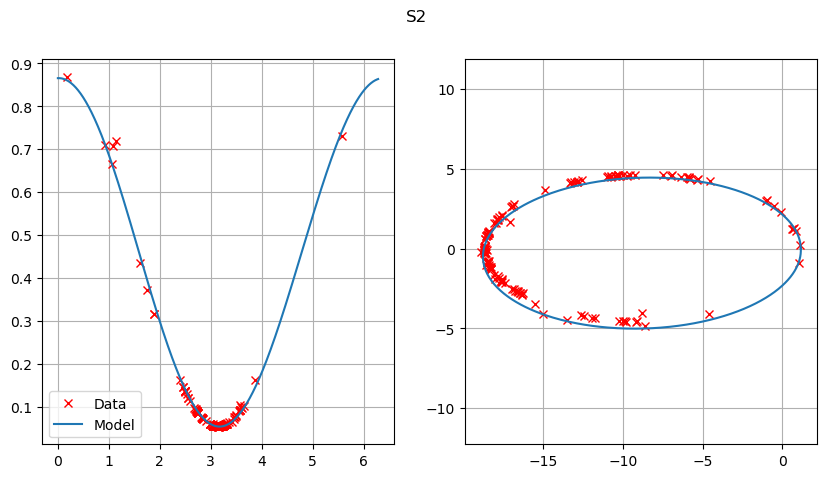

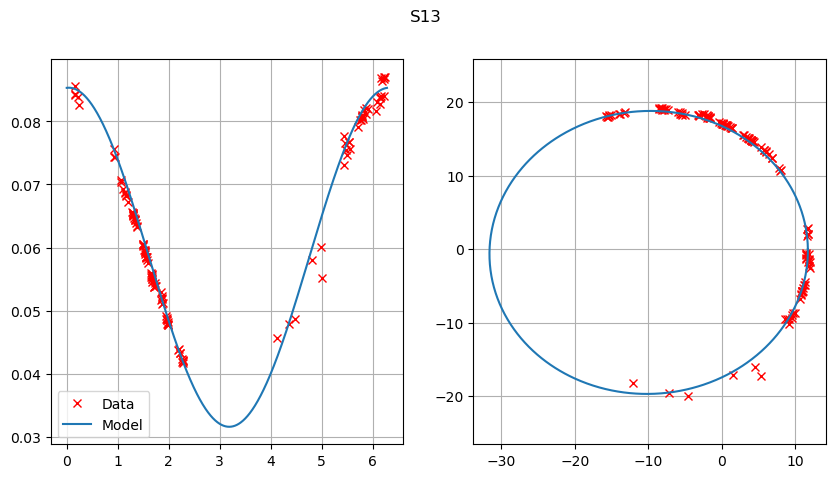

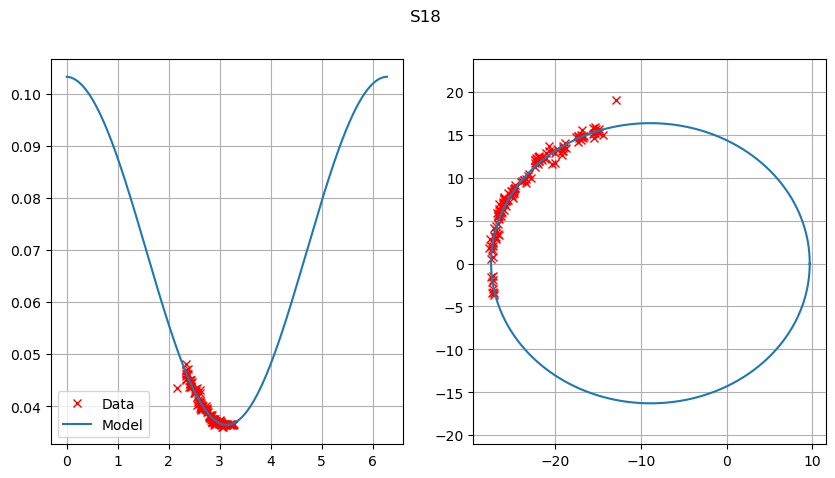

In [96]:


for i, loader in enumerate(loaders):
    fig, ax = plt.subplots(figsize=(10,5), ncols=2)
    fig.suptitle(stars[i])

    ax[0].plot(loader.phi, loader.u, 'rx', label="Data")

    theta = torch.linspace(0, 2*torch.pi, steps=1000, dtype=torch.float32).unsqueeze(1).to(device)
    u_ = model.pinns[i](theta, M=model.get_M()).cpu().detach().numpy()[:,0]
    ax[0].plot(theta, u_, label="Model")
    ax[1].plot(torch.cos(loader.phi[:,0])/loader.u[:,0], torch.sin(loader.phi[:,0])/loader.u[:,0], "rx")

    theta = theta.numpy()
    ax[1].plot(np.cos(theta[:,0])/u_, np.sin(theta[:,0])/u_);

    [axi.grid() for axi in ax]
    ax[1].axis('equal')
    ax[0].legend();




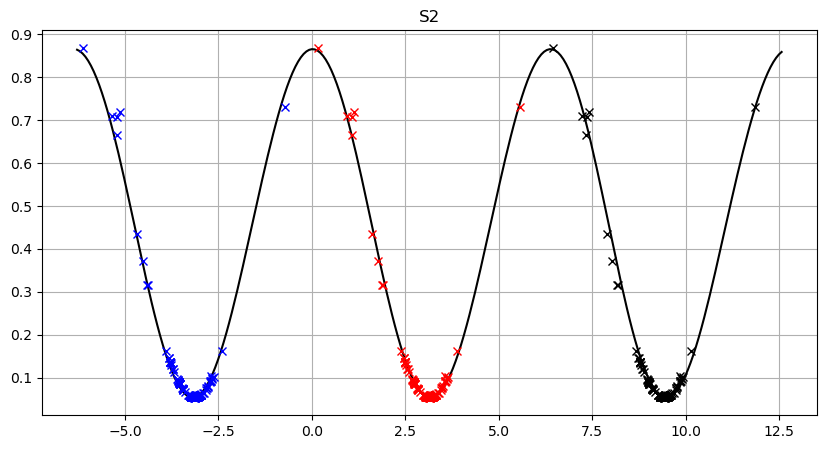

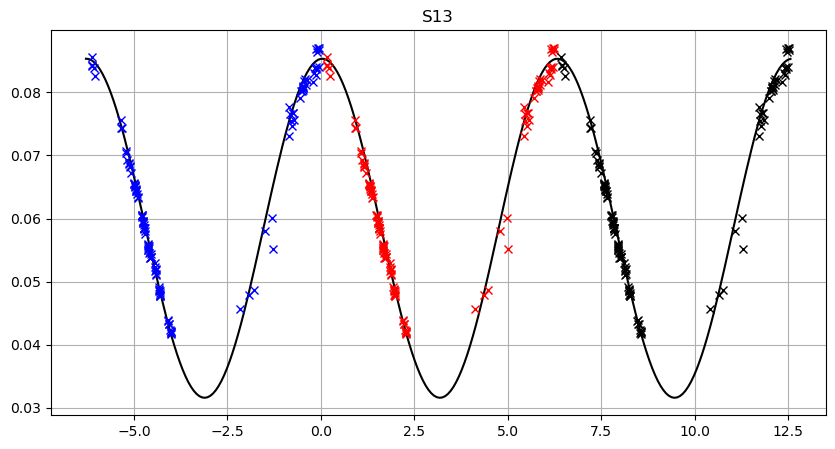

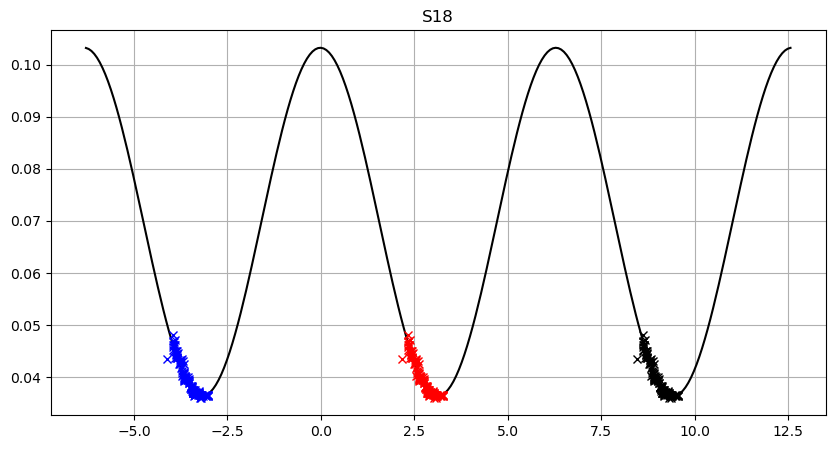

In [97]:
for i, loader in enumerate(loaders):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.grid()

    u_ = model.pinns[i](phi_lin, M=model.get_M()).cpu().detach().numpy()[:,0]
    theta = phi_lin.cpu().detach().numpy()

    ax.set_title(stars[i])
    ax.plot(theta[:,0], u_, 'k')
    ax.plot(loader.phi, loader.u, "rx")
    ax.plot(loader.phi - torch.pi * 2, loader.u, 'bx')
    ax.plot(loader.phi + torch.pi * 2, loader.u, 'kx')



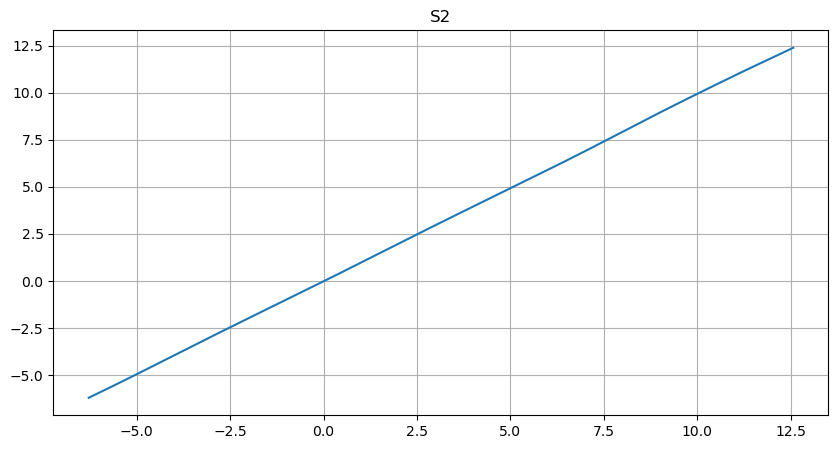

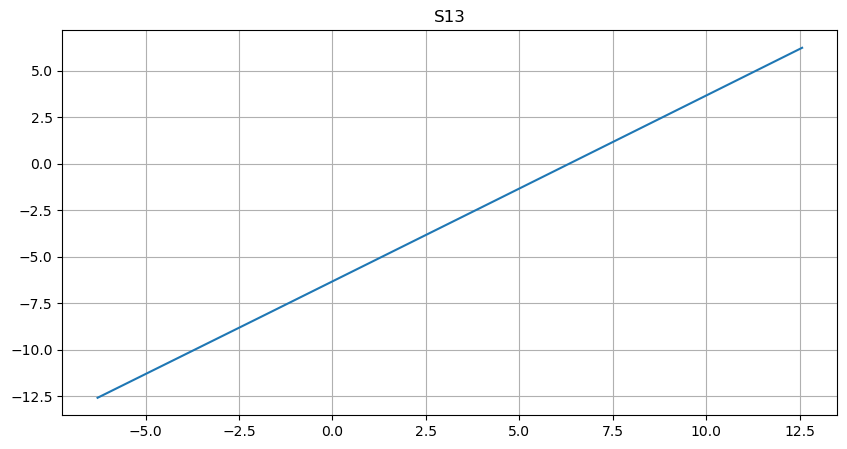

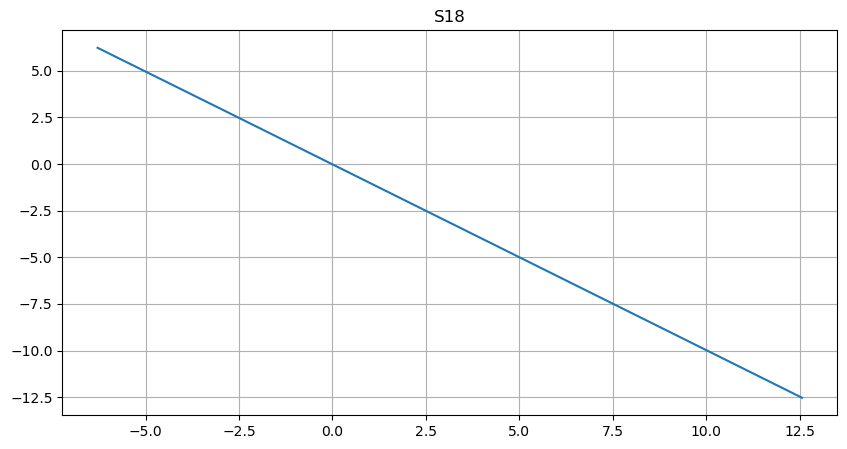

In [98]:

for i, loader in enumerate(loaders):
    y = model.pinns[i].nn(phi_lin).cpu().detach().numpy()

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(phi_lin.detach().numpy(), y)
    ax.grid()
    ax.set_title(stars[i])

In [99]:
state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

#torch.save(state, f'S-STAR-PINN.pth')